# ECG Analysis and Visualization

This notebook loads **pre-processed ECG/HRV features** and performs statistical analysis and visualization.

**Prerequisites**: 
- Run `process_ecg_data.py` first to generate processed HRV features
- Install R and required packages for statistical analysis:
  - `lmerTest` (for mixed-effects modeling)
  - `emmeans` (for estimated marginal means and pairwise comparisons)

**Data Source**: Loads from `data/processed/combined/ecg_features_all.csv`

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Pre-Processed HRV Features

Load the combined HRV features file (generated by `process_ecg_data.py`):

In [2]:
# Load combined HRV features from processed data
features_file = Path('data/processed/combined/ecg_features_all.csv')

if not features_file.exists():
    raise FileNotFoundError(
        f"Processed features file not found: {features_file}\n"
        "Please run 'python process_ecg_data.py' first to generate the features."
    )

all_features_df = pd.read_csv(features_file)

print(f"✓ Loaded {len(all_features_df)} records from {all_features_df['participant'].nunique()} participants")
print(f"✓ Conditions: {sorted(all_features_df['condition'].unique())}")
print(f"✓ Feature columns: {len(all_features_df.columns)}")

✓ Loaded 1681 records from 39 participants
✓ Conditions: ['H', 'L', 'M']
✓ Feature columns: 94


## 3. Explore the Data

Display the first few rows and summary statistics:

In [3]:
# Display first few rows
print("First 10 rows of the dataset:")
display(all_features_df.head(10))

# Display summary statistics for key HRV features
key_features = ['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_pNN50', 
                'HRV_LF', 'HRV_HF', 'HRV_LFHF', 'HRV_SD1', 'HRV_SD2']
available_features = [f for f in key_features if f in all_features_df.columns]

print("\nSummary statistics for key HRV features:")
display(all_features_df[available_features].describe())

# Display data types and missing values
print("\nData info:")
print(f"Shape: {all_features_df.shape}")
print(f"\nMissing values per column (showing top 10):")
missing_counts = all_features_df.isnull().sum().sort_values(ascending=False)
print(missing_counts.head(10))

First 10 rows of the dataset:


,window_index,t_start_sec,t_end_sec,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_SDSD,HRV_CVNN,HRV_CVSD,HRV_MedianNN,HRV_MadNN,HRV_MCVNN,HRV_IQRNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN,HRV_LF,HRV_HF,HRV_VHF,HRV_TP,HRV_LFHF,HRV_LFn,HRV_HFn,HRV_LnHF,HRV_SD1,HRV_SD2,HRV_SD1SD2,HRV_S,HRV_CSI,HRV_CVI,HRV_CSI_Modified,HRV_PIP,HRV_IALS,HRV_PSS,HRV_PAS,HRV_GI,HRV_SI,HRV_AI,HRV_PI,HRV_C1d,HRV_C1a,HRV_SD1d,HRV_SD1a,HRV_C2d,HRV_C2a,HRV_SD2d,HRV_SD2a,HRV_Cd,HRV_Ca,HRV_SDNNd,HRV_SDNNa,HRV_DFA_alpha1,HRV_MFDFA_alpha1_Width,HRV_MFDFA_alpha1_Peak,HRV_MFDFA_alpha1_Mean,HRV_MFDFA_alpha1_Max,HRV_MFDFA_alpha1_Delta,HRV_MFDFA_alpha1_Asymmetry,HRV_MFDFA_alpha1_Fluctuation,HRV_MFDFA_alpha1_Increment,HRV_ApEn,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC,participant,condition,filename,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_VLF,HRV_DFA_alpha2,HRV_MFDFA_alpha2_Width,HRV_MFDFA_alpha2_Peak,HRV_MFDFA_alpha2_Mean,HRV_MFDFA_alpha2_Max,HRV_MFDFA_alpha2_Delta,HRV_MFDFA_alpha2_Asymmetry,HRV_MFDFA_alpha2_Fluctuation,HRV_MFDFA_alpha2_Increment
0,0.0,0.0,60.0,577.623762,11.567931,9.372300,9.419430,0.020027,0.016226,576.0,11.8608,0.020592,20.0,1.234268,568.0,588.0,0.0,0.000000,552.0,608.0,3.884615,46.8750,0.037199,0.016549,0.006391,0.060138,2.247807,0.618551,0.275180,-4.101437,6.660543,14.937743,0.445887,312.567965,2.242722,3.201915,134.004794,0.603960,0.590361,0.836735,0.068966,50.261780,50.268456,50.255119,44.578313,0.444444,0.555556,4.440402,4.964521,0.569190,0.430810,11.269736,9.804550,0.548502,0.451498,8.565166,7.770961,0.993181,0.885346,1.113862,1.374821,-0.294734,-1.171554,-0.205246,0.000218,0.051481,0.505147,1.722767,3.449361,1.376896,1.756109,1.054883,1.396797,1.727547,1.723474,2.630335,0.988843,3239,M,3239_ecg_session02.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,30.0,90.0,580.862745,14.191086,10.386587,10.436493,0.024431,0.017881,580.0,17.7912,0.030674,23.0,1.366290,568.0,592.0,0.0,0.980392,548.0,620.0,4.434783,54.6875,0.045837,0.004692,0.007486,0.058016,9.768470,0.790082,0.080881,-5.361813,7.379715,18.702634,0.394582,433.602975,2.534330,3.344062,189.594585,0.607843,0.600000,0.862745,0.103448,48.815166,48.823831,48.806940,45.882353,0.421439,0.578561,4.791659,5.614268,0.598630,0.401370,14.470448,11.848825,0.574751,0.425249,10.778540,9.271317,1.244970,0.679773,1.290022,1.584856,-0.578826,-1.594625,-0.066275,0.000261,0.034167,0.470031,2.322388,3.728816,1.270274,1.233389,1.210057,1.488358,1.764065,1.618568,2.639974,0.850407,3239,M,3239_ecg_session02.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,60.0,120.0,581.450980,15.948325,11.306705,11.354661,0.027428,0.019446,580.0,17.7912,0.030674,20.0,1.410519,568.0,592.0,0.0,2.941176,548.0,624.0,3.517241,46.8750,0.048348,0.008869,0.009507,0.066725,5.451298,0.724597,0.132922,-4.725175,8.028957,20.902072,0.384123,527.227895,2.603336,3.428968,217.660454,0.607843,0.602273,0.867925,0.172414,52.380952,52.440905,52.321832,45.454545,0.501859,0.498141,5.692100,5.670979,0.567101,0.432899,15.740537,13.752532,0.558701,0.441299,11.835635,10.518844,1.248808,0.372701,1.309525,1.317346,-0.111747,-1.103994,-0.479014,0.000270,0.014531,0.441873,2.639057,3.827071,1.224824,1.702632,0.823748,1.432517,1.720416,1.615148,2.179883,0.784991,3239,M,3239_ecg_session02.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,90.0,150.0,580.543689,13.743288,10.619996,10.670621,0.023673,0.018293,580.0,11.8608,0.020450,16.0,1.294095,568.0,588.0,0.0,1.941748,548.0,624.0,3.322581,46.8750,0.051705,0.024687,0.011404,0.087796,2.094382,0.588916,0.281188,-3.701464,7.545269,17.956504,0.420197,425.643860,2.379836,3.336016,170.934152,0.669903,0.670732,0.872727,0.318182,48.826291,48.817342,48.835804,47.560976,0.461752,0.538248,5.128063,5.536557,0.497140,0.502860,12.660800,12.733427,0.491828,0.508172,9.659008,9.818188,1.145216,0.465949,1.244322,1.295154,-0.128788,-1.128788,-0.390907,0.000518,0.025031,0.492752,1


Summary statistics for key HRV features:


,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_pNN50,HRV_LF,HRV_HF,HRV_LFHF,HRV_SD1,HRV_SD2
count,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1.681000e+03,1681.000000,1681.000000,1681.000000
mean,734.352758,128.542096,145.704075,22.351424,0.033121,3.942291e-02,2.410562,104.158814,146.680848
std,718.466344,596.652895,734.439608,29.628647,0.016170,3.522073e-02,24.980122,540.145683,672.559331
min,419.942857,4.662776,3.819455,0.000000,0.000114,1.114723e-07,0.042877,2.713957,5.867693
25%,632.765957,26.628911,17.823101,0.000000,0.018787,1.280281e-02,0.515924,12.673877,34.270326
50%,689.023256,37.058566,29.437742,6.896552,0.033570,2.646512e-02,1.049913,20.982652,47.350633
75%,804.432432,55.894859,47.965674,30.136986,0.047585,5.688248e-02,2.230148,34.162448,71.900598
max,29733.538462,23127.275472,28408.279920,95.061728,0.070332,1.686723e-01,1022.554081,20974.607401,26150.983304



Data info:
Shape: (1681, 94)

Missing values per column (showing top 10):
HRV_SDANN1                    1680
HRV_SDNNI1                    1680
HRV_SDANN2                    1680
HRV_SDNNI2                    1680
HRV_VLF                       1680
HRV_MFDFA_alpha2_Increment    1651
HRV_MFDFA_alpha2_Width        1651
HRV_DFA_alpha2                1651
HRV_MFDFA_alpha2_Peak         1651
HRV_MFDFA_alpha2_Mean         1651
dtype: int64


## 4. Condition-Level Summary Statistics

Compute mean and standard error for each metric by condition:

In [4]:
# Compute summary statistics by condition for key HRV features
summary_features = {
    'HRV_MeanNN': ['mean', 'std', 'sem'],
    'HRV_SDNN': ['mean', 'std', 'sem'],
    'HRV_RMSSD': ['mean', 'std', 'sem'],
    'HRV_pNN50': ['mean', 'std', 'sem'],
    'HRV_LF': ['mean', 'std', 'sem'],
    'HRV_HF': ['mean', 'std', 'sem'],
    'HRV_LFHF': ['mean', 'std', 'sem'],
    'HRV_SD1': ['mean', 'std', 'sem'],
    'HRV_SD2': ['mean', 'std', 'sem']
}

# Filter to features that exist
summary_features = {k: v for k, v in summary_features.items() if k in all_features_df.columns}

summary_stats = all_features_df.groupby('condition').agg(summary_features).round(3)

print("Summary Statistics by Condition:")
display(summary_stats)

# Also show counts by participant and condition
print("\nRecords per Participant and Condition:")
record_counts = all_features_df.groupby(['participant', 'condition']).size().unstack(fill_value=0)
display(record_counts.describe())

Summary Statistics by Condition:


HRV_MeanNN                   HRV_SDNN                  HRV_RMSSD  \
                mean       std     sem     mean      std     sem      mean   
condition                                                                    
H            789.156  1222.045  51.141  178.648  993.507  41.577   207.112   
L            699.796   111.057   4.714   94.567  166.257   7.057   104.872   
M            712.526   108.292   4.597  110.967  179.699   7.628   123.357   

                            HRV_pNN50                HRV_LF                \
                std     sem      mean     std    sem   mean    std    sem   
condition                                                                   
H          1221.936  51.136    24.328  31.349  1.312  0.032  0.016  0.001   
L           209.016   8.872    20.183  28.064  1.191  0.034  0.017  0.001   
M           223.014   9.466    22.486  29.233  1.241  0.033  0.016  0.001   

          HRV_HF               HRV_LFHF                 HRV_SD1           \
            mean    std    sem     mean     std    sem     mean      std   
condition                                                                  
H          0.040  0.036  0.001    3.556  42.771  1.790  148.826  900.442   
L          0.038  0.036  0.002    1.926   1.993  0.085   74.617  148.859   
M          0.040  0.034  0.001    1.717   2.008  0.085   87.746  158.681   

                   HRV_SD2                    
              sem     mean       std     sem  
condition                                     
H          37.682  202.080  1121.087  46.916  
L           6.319  108.968   183.318   7.781  
M           6.736  127.397   200.008   8.490


Records per Participant and Condition:


condition,H,L,M
count,39.000000,39.000000,39.000000
mean,14.641026,14.230769,14.230769
std,2.241794,3.351838,3.351838
min,1.000000,0.000000,0.000000
25%,15.000000,15.000000,15.000000
50%,15.000000,15.000000,15.000000
75%,15.000000,15.000000,15.000000
max,15.000000,15.000000,15.000000


## 5. Add Session Order Information for Statistical Analysis

Load participant info and add session order variables needed for mixed effects models:

In [5]:
# Load participant info to get session order (using pose utilities)
import sys
sys.path.append('..')
from Pose.utils.io_utils import load_participant_info_file

# Load participant info file
participant_info_path = load_participant_info_file()
participant_info = pd.read_csv(participant_info_path)

print(f"✓ Loaded participant info from: {participant_info_path}")

# Create session_order column (e.g., "LMH", "LHM")
if {"session01", "session02", "session03"}.issubset(participant_info.columns):
    participant_info["session_order"] = (
        participant_info["session01"].str[0] +
        participant_info["session02"].str[0] +
        participant_info["session03"].str[0]
    )
    
    # Map session_order to numeric values
    session_order_numeric_map = {
        "LMH": 1, 
        "LHM": 2, 
        "MLH": 3, 
        "MHL": 4, 
        "HLM": 5, 
        "HML": 6
    }
    
    participant_info["session_order_numeric"] = participant_info["session_order"].map(session_order_numeric_map)
    
    # Create a mapping from participant ID to session_order_numeric
    session_order_map = participant_info.set_index("Participant ID")["session_order_numeric"].to_dict()
    
    # Add session_order_numeric to all_features_df
    all_features_df["session_order_numeric"] = all_features_df["participant"].astype(int).map(session_order_map)
    
    # Add window_index column for compatibility with stats_figures.py
    # ECG features are session-level (not windowed), so set to 0 for all records
    all_features_df["window_index"] = 0
    
    print(f"✓ Added session order information")
    print(f"  Unique session orders: {sorted(participant_info['session_order'].unique())}")
    print(f"  Session order distribution:")
    print(participant_info['session_order'].value_counts().sort_index())
    print(f"✓ Added window_index column (set to 0 for session-level ECG data)")
else:
    raise ValueError("Participant info file missing required columns: session01, session02, session03")

✓ Loaded participant info from: /Users/mikerichardson/Library/CloudStorage/OneDrive-SharedLibraries-MacquarieUniversity/Complexity in Action - Research/Mind and Interaction Dynamics/PNAS-MATB/participant_info.csv
✓ Added session order information
  Unique session orders: ['---', 'LHM', 'LMH']
  Session order distribution:
session_order
---     1
LHM    24
LMH    25
Name: count, dtype: int64
✓ Added window_index column (set to 0 for session-level ECG data)


## 6. Statistical Analysis Using Linear Mixed Effects Models

Run mixed effects models and create visualizations for key HRV metrics:

In [6]:
import sys
sys.path.append('..')  # Add parent directory
from stats_utils.stats_figures import run_rpy2_lmer, barplot_ax

# Define relevant metrics and labels for statistical analysis
metrics = [
    ("HRV_MeanNN", "Mean NN Interval (ms)"),
    ("HRV_SDNN", "SDNN (ms)"),
    ("HRV_RMSSD", "RMSSD (ms)"),
    ("HRV_pNN50", "pNN50 (%)"),
    ("HRV_LF", "LF Power"),
    ("HRV_HF", "HF Power"),
    ("HRV_LFHF", "LF/HF Ratio"),
    ("HRV_SD1", "SD1 (Poincaré)"),
    ("HRV_SD2", "SD2 (Poincaré)")
]

# Filter to metrics that exist in the data
metrics = [(m, l) for m, l in metrics if m in all_features_df.columns]

print(f"✓ Imported statistical utilities")
print(f"  Running analysis on {len(metrics)} HRV metrics")

✓ Imported statistical utilities
  Running analysis on 9 HRV metrics


R callback write-console: Loading required package: lme4
  
R callback write-console: Loading required package: Matrix
  



Mean NN Interval (ms)
Means for HRV_MeanNN:
  H: 789.156
  L: 699.796
  M: 712.526


R callback write-console: 
Attaching package: ‘lmerTest’

  
R callback write-console: The following object is masked from ‘package:lme4’:

    lmer

  
R callback write-console: The following object is masked from ‘package:stats’:

    step

  
R callback write-console: Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'
  
R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1:   
R callback write-console: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :  
R callback write-console: 
   
R callback write-console:  unable to evaluate scaled gradient
  
R callback write-console: 2:   
R callback write-console: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :  
R callback write-console: 
   
R callback write-console


=== Mean NN Interval (ms) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 19365.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5141 -0.2214 -0.0057  0.2015 11.6180 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 21767193 4665.53 
 Residual                       4566   67.57 
Number of obs: 1681, groups:  participant_id, 39

Fixed effects:
                       Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)           -468.5630  2527.4967   36.9861  -0.185    0.854    
condition.L             17.9793     2.8683 1639.9871   6.268 4.65e-10 ***
condition.Q             -0.0142     2.8683 1639.9863  -0.005    0.996    
session_order_numeric 1218.7867  1518.8381   36.9863   0.802    0.427    
---
Signif. codes:  0 ‘***’ 0.001

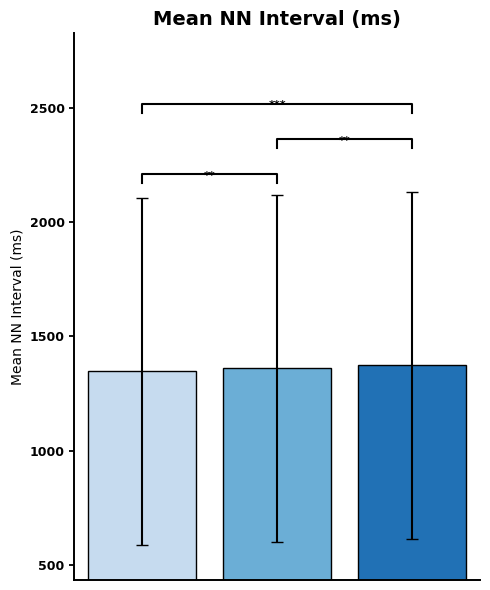

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



SDNN (ms)
Means for HRV_SDNN:
  H: 178.648
  L: 94.567
  M: 110.967

=== SDNN (ms) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 19923.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.1030 -0.1296 -0.0382  0.1099 12.3497 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 13715419 3703.43 
 Residual                       6482   80.51 
Number of obs: 1681, groups:  participant_id, 39

Fixed effects:
                      Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)           -826.687   2006.299   36.967  -0.412 0.682685    
condition.L             12.330      3.418 1639.971   3.608 0.000318 ***
condition.Q             -6.272      3.418 1639.969  -1.835 0.066666 .  
session_order_numeric  973.822   1205.639   36.968   0.808

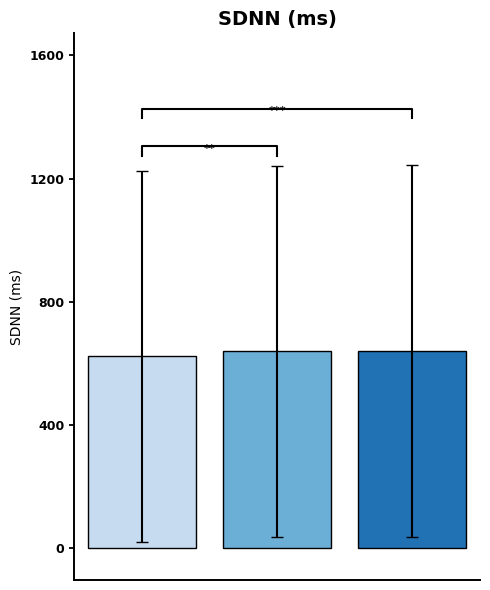

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



RMSSD (ms)
Means for HRV_RMSSD:
  H: 207.112
  L: 104.872
  M: 123.357

=== RMSSD (ms) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 20377.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.9142 -0.0925 -0.0489  0.1171 11.6772 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 20719494 4551.87 
 Residual                       8471   92.04 
Number of obs: 1681, groups:  participant_id, 39

Fixed effects:
                       Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)           -1026.005   2465.927    36.971  -0.416 0.679762    
condition.L              14.021      3.907  1639.975   3.589 0.000342 ***
condition.Q              -6.998      3.907  1639.973  -1.791 0.073420 .  
session_order_numeric  1195.599   1481.841    

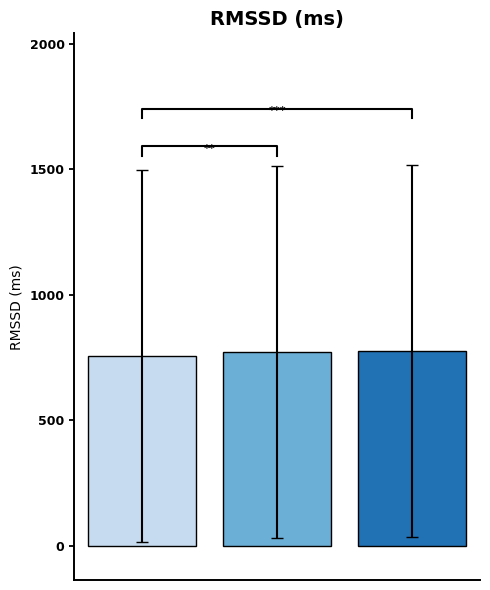

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



pNN50 (%)
Means for HRV_pNN50:
  H: 24.328
  L: 20.183
  M: 22.486

=== pNN50 (%) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 11390

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.9336 -0.3118 -0.0682  0.3123  4.1892 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 995.00   31.544  
 Residual                    44.19    6.648  
Number of obs: 1681, groups:  participant_id, 39

Fixed effects:
                       Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)             19.6568    17.1000   36.7535   1.150  0.25777    
condition.L              1.6682     0.2822 1640.0482   5.912 4.11e-09 ***
condition.Q             -0.9175     0.2822 1639.8888  -3.252  0.00117 ** 
session_order_numeric    3.3029    10.2781   36.7846 

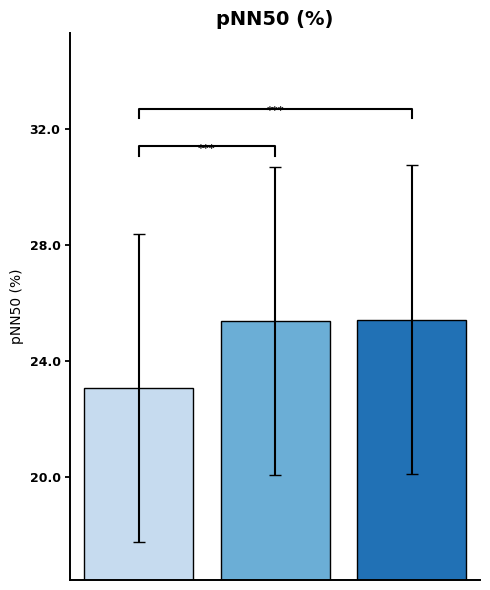

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



LF Power
Means for HRV_LF:
  H: 0.032
  L: 0.034
  M: 0.033

=== LF Power (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -9246.1

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.46553 -0.82796  0.01557  0.80520  2.41878 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 4.158e-05 0.006448
 Residual                   2.216e-04 0.014886
Number of obs: 1681, groups:  participant_id, 39

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            3.256e-02  3.722e-03  3.576e+01   8.748 2.06e-10 ***
condition.L           -1.542e-03  6.306e-04  1.649e+03  -2.446   0.0145 *  
condition.Q           -7.448e-05  6.314e-04  1.643e+03  -0.118   0.9061    
session_order_numeric  2.845e-04  2.24

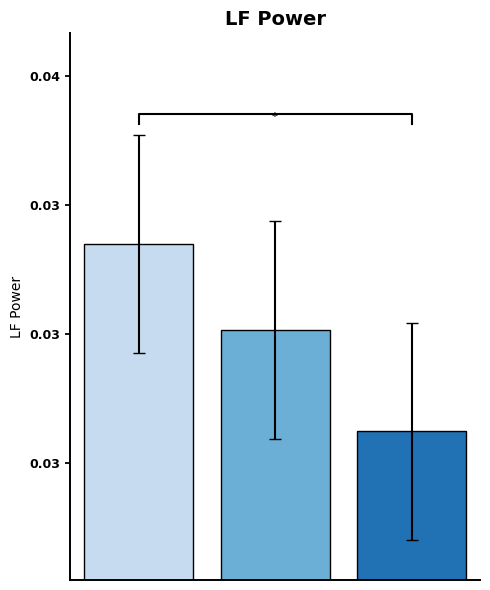

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



HF Power
Means for HRV_HF:
  H: 0.040
  L: 0.038
  M: 0.040

=== HF Power (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -7757.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8997 -0.5388 -0.1290  0.4749  4.8334 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 0.0007533 0.02745 
 Residual                   0.0005161 0.02272 
Number of obs: 1681, groups:  participant_id, 39

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)            3.594e-02  1.501e-02  3.644e+01   2.394   0.0219 *
condition.L            1.651e-03  9.639e-04  1.643e+03   1.713   0.0868 .
condition.Q           -3.362e-04  9.642e-04  1.641e+03  -0.349   0.7274  
session_order_numeric  1.796e-03  9.040e-03  3.661e+01  

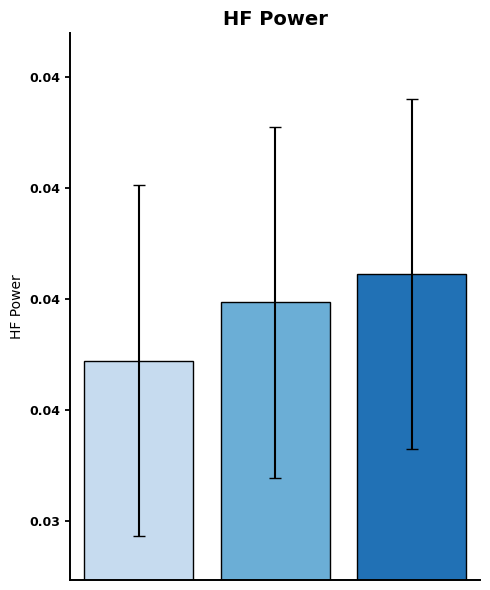

R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  



LF/HF Ratio
Means for HRV_LFHF:
  H: 3.556
  L: 1.926
  M: 1.717

=== LF/HF Ratio (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 6632.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5041 -0.4035 -0.1225  0.2117  7.4390 

Random effects:
 Groups         Name        Variance  Std.Dev.
 participant_id (Intercept) 26942.844 164.143 
 Residual                       2.255   1.502 
Number of obs: 1681, groups:  participant_id, 39

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)            -42.04542   88.92221   36.99731  -0.473   0.6391  
condition.L             -0.13804    0.06374 1639.99490  -2.166   0.0305 *
condition.Q              0.09119    0.06374 1639.99459   1.431   0.1527  
session_order_numeric   44.06138   53.43562   36.

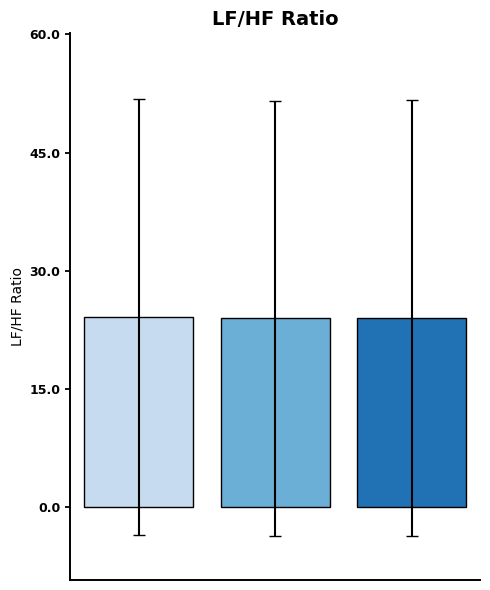


SD1 (Poincaré)
Means for HRV_SD1:
  H: 148.826
  L: 74.617
  M: 87.746


R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  
R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1:   
R callback write-console: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :  
R callback write-console: 
   
R callback write-console:  unable to evaluate scaled gradient
  
R callback write-console: 2:   
R callback write-console: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :  
R callback write-console: 
   
R callback write-console:  Model failed to converge: degenerate  Hessian with 1 negative eigenvalues
  



=== SD1 (Poincaré) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 19251.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.9364 -0.0922 -0.0485  0.1164 11.6597 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 11296422 3361.02 
 Residual                       4323   65.75 
Number of obs: 1681, groups:  participant_id, 39

Fixed effects:
                      Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)           -762.617   1820.795   36.974  -0.419 0.677758    
condition.L              9.984      2.791 1639.976   3.577 0.000357 ***
condition.Q             -4.955      2.791 1639.975  -1.775 0.076004 .  
session_order_numeric  883.550   1094.164   36.974   0.808 0.424536    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.

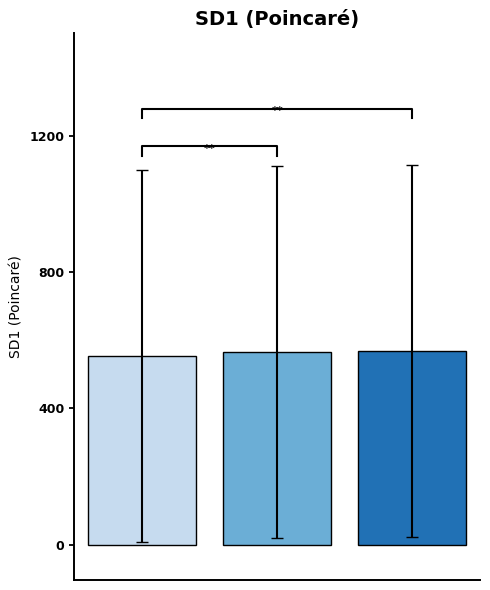


SD2 (Poincaré)


R callback write-console: fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
  


Means for HRV_SD2:
  H: 202.080
  L: 108.968
  M: 127.397

=== SD2 (Poincaré) (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 20554.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.1715 -0.1368 -0.0342  0.1065 14.1906 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 17525537 4186.35 
 Residual                       9471   97.32 
Number of obs: 1681, groups:  participant_id, 39

Fixed effects:
                      Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)           -939.422   2267.918   36.962  -0.414 0.681105    
condition.L             13.841      4.131 1639.967   3.351 0.000825 ***
condition.Q             -7.056      4.131 1639.965  -1.708 0.087829 .  
session_order_numeric 1104.123   1362.853   36.963   0.810 0.423

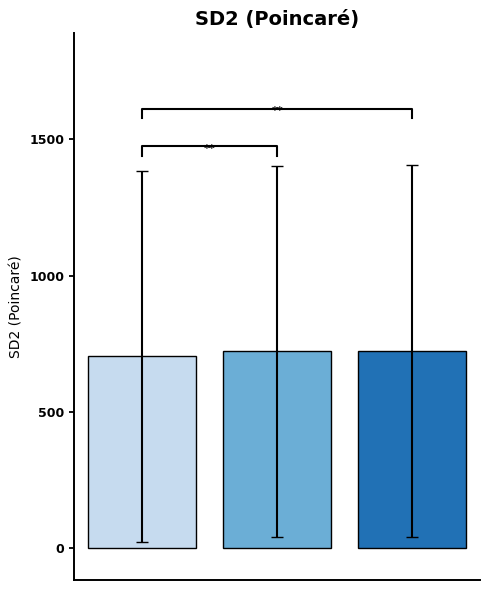


✓ Statistical analysis complete!


In [7]:
# Run statistical analysis for key HRV metrics
for metric, label in metrics:
    print(f"\n{'='*60}")
    print(f"{label}")
    print(f"{'='*60}")
    
    # Run mixed effects model and get stats
    pairwise_p, means, cis = run_rpy2_lmer(
        all_features_df, metric, label
    )
    
    # Prepare data for plotting
    conds = ["L", "M", "H"]
    mean_vals = [means.get(c, float('nan')) for c in conds]
    sems = [(cis[c][1] - cis[c][0]) / 3.92 if c in cis else float('nan') for c in conds]  # 95% CI to SEM
    pvals = [
        pairwise_p.get(("L", "M"), 1.0), 
        pairwise_p.get(("L", "H"), 1.0), 
        pairwise_p.get(("M", "H"), 1.0)
    ]
    
    # Create plot
    fig, ax = plt.subplots(figsize=(5, 6))
    barplot_ax(ax, mean_vals, sems, pvals, ylabel=label, metric_name=metric)
    ax.set_title(label, fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()

print("\n✓ Statistical analysis complete!")